In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Si ya tienes imbalanced-learn, puedes saltarte esta celda.
!pip -q install imbalanced-learn


In [3]:
import sys, json, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Si tu archivo está en Google Drive, descomenta:
# from google.colab import drive
# drive.mount('/content/drive')
# RUTA_CSV = "/content/drive/MyDrive/tu_carpeta/telco_entregable_unico.csv"

RUTA_CSV = "telco_entregable_unico.csv"   # <- el de tu screenshot
OUTPUT_DIR = Path("outputs"); OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

df0 = pd.read_csv(RUTA_CSV)
print("Shape:", df0.shape)
print("Cols:", list(df0.columns))
df0.head()


Shape: (7267, 23)
Cols: ['Activo', 'Género', 'Ciudadano_65+', 'Pareja', 'Dependientes', 'Meses_Contrato', 'Servicio_Teléfono', 'Varias_Líneas', 'Servicio_Internet', 'Seguridad_Online', 'Respaldo_Online', 'Protección_Dispositivo', 'Soporte_Técnico', 'Streaming_TV', 'Streaming_Películas', 'Contrato', 'Factura_Electrónica', 'Método_Pago', 'Cargos_Mensuales', 'Cargo_Total', 'ID', 'Cargos_Diarios', 'Bucket_Tenure']


,Activo,Género,Ciudadano_65+,Pareja,Dependientes,Meses_Contrato,Servicio_Teléfono,Varias_Líneas,Servicio_Internet,Seguridad_Online,...,Streaming_TV,Streaming_Películas,Contrato,Factura_Electrónica,Método_Pago,Cargos_Mensuales,Cargo_Total,ID,Cargos_Diarios,Bucket_Tenure
0,0.0,Female,0,True,True,9,True,0,DSL,0,...,1,0,One year,True,Mailed check,65.6,593.30,0002-ORFBO,2.19,7-12
1,0.0,Male,0,False,False,9,True,1,DSL,0,...,0,1,Month-to-month,False,Mailed check,59.9,542.40,0003-MKNFE,2.00,7-12
2,1.0,Male,0,False,False,4,True,0,Fiber optic,0,...,0,0,Month-to-month,True,Electronic check,73.9,280.85,0004-TLHLJ,2.46,0-6
3,1.0,Male,1,True,False,13,True,0,Fiber optic,0,...,1,1,Month-to-month,True,Electronic check,98.0,1237.85,0011-IGKFF,3.27,13-24
4,1.0,Female,1,True,False,3,True,0,Fiber optic,0,...,1,0,Month-to-month,True,Mailed check,83.9,267.40,0013-EXCHZ,2.80,0-6


In [4]:
# Mapea nombres de tu CSV a los esperados por la Parte 2
alias = {
    "Ciudadano_65+": "Mayor_de_65_años",
    "Dependientes": "Tiene_Dependientes",
    "Meses_Contrato": "Meses_Contratados",
    "Contrato": "Tipo_de_Contrato",
    "Método_Pago": "Metodo_Pago",
    "Cargos_Mensuales": "Cobro_Mensual",
    "Cargo_Total": "Gasto_Total",
}
df = df0.rename(columns=alias).copy()

# Si no viene 'Cliente_cancelado', créalo desde 'Activo' (1=activo, 0=se fue)
if "Cliente_cancelado" not in df.columns:
    if "Activo" not in df.columns:
        raise KeyError("No encuentro 'Cliente_cancelado' ni 'Activo' en el CSV.")
    df["Cliente_cancelado"] = (1 - pd.to_numeric(df["Activo"], errors="coerce")).astype("Int64")

# Booleans -> Int64 (por si se usan como numéricos)
for c in ["Pareja", "Servicio_Teléfono", "Factura_Electrónica"]:
    if c in df.columns:
        df[c] = df[c].astype("boolean").astype("Int64")

# Tipos numéricos seguros
for c in ["Meses_Contratados", "Cobro_Mensual", "Gasto_Total"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Selección de columnas base (se toman solo las que existan)
base = [
    "Cliente_cancelado",
    "Mayor_de_65_años",
    "Tiene_Dependientes",
    "Meses_Contratados",
    "Tipo_de_Contrato",
    "Metodo_Pago",
    "Cobro_Mensual",
    "Gasto_Total",
]
extras = ["Servicio_Internet", "Género", "Servicio_Teléfono"]  # opcionales si están
cols_finales = [c for c in base + extras if c in df.columns]
df = df[cols_finales].copy()

print("Columnas usadas:", cols_finales)
df.head()


Columnas usadas: ['Cliente_cancelado', 'Mayor_de_65_años', 'Tiene_Dependientes', 'Meses_Contratados', 'Tipo_de_Contrato', 'Metodo_Pago', 'Cobro_Mensual', 'Gasto_Total', 'Servicio_Internet', 'Género', 'Servicio_Teléfono']


,Cliente_cancelado,Mayor_de_65_años,Tiene_Dependientes,Meses_Contratados,Tipo_de_Contrato,Metodo_Pago,Cobro_Mensual,Gasto_Total,Servicio_Internet,Género,Servicio_Teléfono
0,1,0,True,9,One year,Mailed check,65.6,593.30,DSL,Female,1
1,1,0,False,9,Month-to-month,Mailed check,59.9,542.40,DSL,Male,1
2,0,0,False,4,Month-to-month,Electronic check,73.9,280.85,Fiber optic,Male,1
3,0,1,False,13,Month-to-month,Electronic check,98.0,1237.85,Fiber optic,Male,1
4,0,1,False,3,Month-to-month,Mailed check,83.9,267.40,Fiber optic,Female,1


In [6]:
from sklearn.model_selection import train_test_split

# Mapear 'Si/No' → 1/0 si aún hay texto
def map_sino(s):
    s = s.astype(str).str.strip().str.lower().replace({"sí": "si"})
    return s.map({"si":1, "no":0})

for c in ["Mayor_de_65_años","Tiene_Dependientes"]:
    if c in df.columns and df[c].dtype == object:
        df[c] = map_sino(df[c]).astype("Int64")

# Drop rows with NaN in the target variable
df.dropna(subset=["Cliente_cancelado"], inplace=True)

# Split
y = df["Cliente_cancelado"].astype("Int64")
X = df.drop(columns=["Cliente_cancelado"])

numeric_features = [c for c in [
    "Meses_Contratados","Cobro_Mensual","Gasto_Total",
    "Mayor_de_65_años","Tiene_Dependientes","Servicio_Teléfono"
] if c in X.columns]

categorical_features = [c for c in [
    "Tipo_de_Contrato","Metodo_Pago","Servicio_Internet","Género"
] if c in X.columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Proporción de cancelaciones (train/test):",
      f"{y_train.mean():.2%} / {y_test.mean():.2%}")

Train: (5634, 10)  Test: (1409, 10)
Proporción de cancelaciones (train/test): 73.46% / 73.46%


In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler(with_mean=False)),
])
cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore")),
])
preprocess = ColumnTransformer(
    [("num", num_pipe, numeric_features),
     ("cat", cat_pipe, categorical_features)],
    remainder="drop", sparse_threshold=1.0
)

modelos = {
    "logreg_weighted": Pipeline([
        ("prep", preprocess),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced")),
    ]),
    "logreg_smote": ImbPipeline([
        ("prep", preprocess),
        ("smote", SMOTE(random_state=42)),
        ("clf", LogisticRegression(max_iter=1000)),
    ]),
    "rf_weighted": Pipeline([
        ("prep", preprocess),
        ("clf", RandomForestClassifier(
            n_estimators=400, random_state=42,
            class_weight="balanced_subsample", n_jobs=-1
        )),
    ]),
}
modelos

{'logreg_weighted': Pipeline(steps=[('prep',
                  ColumnTransformer(sparse_threshold=1.0,
                                    transformers=[('num',
                                                   Pipeline(steps=[('imp',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('sc',
                                                                    StandardScaler(with_mean=False))]),
                                                   ['Meses_Contratados',
                                                    'Cobro_Mensual',
                                                    'Gasto_Total',
                                                    'Mayor_de_65_años',
                                                    'Tiene_Dependientes',
                                                    'Servicio_Teléfono']),
                                                  ('c

In [11]:
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, average_precision_score, accuracy_score,
    precision_score, recall_score, f1_score,
)
import numpy as np
import pandas as pd

def evaluar(nombre, pipe):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    try:
        y_prob = pipe.predict_proba(X_test)[:,1]
        roc = roc_auc_score(y_test, y_prob)
        pr  = average_precision_score(y_test, y_prob)
    except Exception:
        y_prob, roc, pr = None, np.nan, np.nan
    met = {
        "modelo": nombre,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision_1": precision_score(y_test, y_pred, zero_division=0),
        "recall_1": recall_score(y_test, y_pred, zero_division=0),
        "f1_1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc, "pr_auc": pr,
        "y_pred": y_pred, "y_prob": y_prob, "pipe": pipe
    }
    print(f"\n=== {nombre.upper()} ===")
    print(classification_report(y_test, y_pred, target_names=["No canceló","Canceló"]))
    return met

res = [evaluar(n,p) for n,p in modelos.items()]
res_df = pd.DataFrame([{k:v for k,v in r.items() if k not in ("pipe","y_pred","y_prob")} for r in res])
display(res_df.sort_values(["roc_auc","f1_1","recall_1"], ascending=False))

best = max(res, key=lambda r: (np.nan_to_num(r["roc_auc"]), r["f1_1"]))
best_name = best["modelo"]; best_pipe = best["pipe"]
print(f"\n🥇 Mejor: {best_name}  (ROC AUC={best['roc_auc']:.3f} | F1={best['f1_1']:.3f} | Recall={best['recall_1']:.3f})")



=== LOGREG_WEIGHTED ===
              precision    recall  f1-score   support

  No canceló       0.52      0.83      0.64       374
     Canceló       0.92      0.72      0.81      1035

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409


=== LOGREG_SMOTE ===
              precision    recall  f1-score   support

  No canceló       0.52      0.83      0.64       374
     Canceló       0.92      0.72      0.81      1035

    accuracy                           0.75      1409
   macro avg       0.72      0.78      0.72      1409
weighted avg       0.81      0.75      0.76      1409


=== RF_WEIGHTED ===
              precision    recall  f1-score   support

  No canceló       0.64      0.51      0.56       374
     Canceló       0.83      0.89      0.86      1035

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weight

,modelo,accuracy,precision_1,recall_1,f1_1,roc_auc,pr_auc
1,logreg_smote,0.748048,0.922886,0.716908,0.806960,0.852175,0.937992
0,logreg_weighted,0.748048,0.919753,0.719807,0.807588,0.851989,0.938075
2,rf_weighted,0.792051,0.834234,0.894686,0.863403,0.818463,0.921262



🥇 Mejor: logreg_smote  (ROC AUC=0.852 | F1=0.807 | Recall=0.717)


<Figure size 640x480 with 0 Axes>

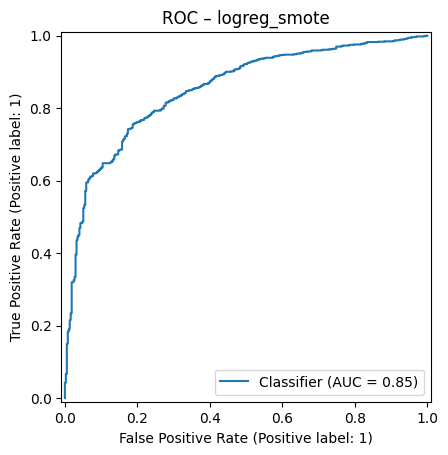

<Figure size 640x480 with 0 Axes>

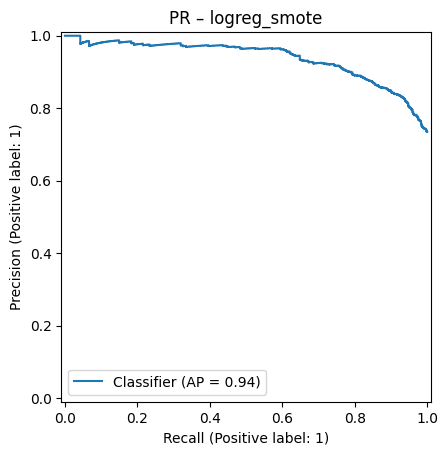

<Figure size 640x480 with 0 Axes>

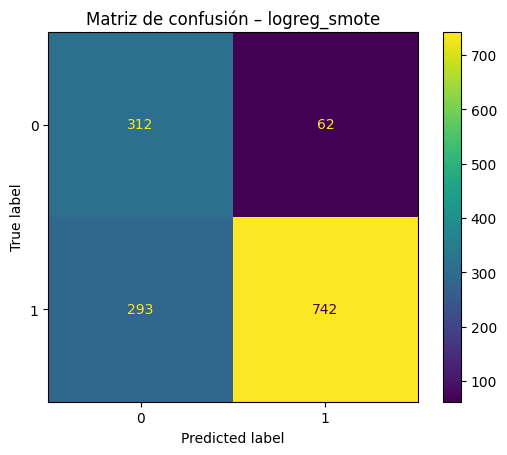

In [12]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

if best["y_prob"] is not None:
    plt.figure(); RocCurveDisplay.from_predictions(y_test, best["y_prob"]); plt.title(f"ROC – {best_name}"); plt.show()
    plt.figure(); PrecisionRecallDisplay.from_predictions(y_test, best["y_prob"]); plt.title(f"PR – {best_name}"); plt.show()

plt.figure()
ConfusionMatrixDisplay(confusion_matrix(y_test, best["y_pred"])).plot(values_format="d")
plt.title(f"Matriz de confusión – {best_name}")
plt.show()


In [13]:
df_out = df.copy()  # dataset analítico mapeado
csv_out = OUTPUT_DIR / "telco_parte2_unico.csv"
df_out.to_csv(csv_out, index=False, encoding="utf-8-sig")

metrics_best = {k: float(best[k]) if isinstance(best[k], (int,float,np.floating)) else best[k]
                for k in ["accuracy","precision_1","recall_1","f1_1","roc_auc","pr_auc"]}
json_out = OUTPUT_DIR / "metrics_parte2.json"
json_out.write_text(json.dumps(metrics_best, indent=2, ensure_ascii=False), encoding="utf-8")

print("✅ CSV único:", csv_out.resolve())
print("✅ Métricas:", json_out.resolve())


✅ CSV único: /content/outputs/telco_parte2_unico.csv
✅ Métricas: /content/outputs/metrics_parte2.json


In [14]:
try:
    if "rf_weighted" in best_name:
        # Recuperar nombres post-OHE
        ohe = best_pipe.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
        cat_names = ohe.get_feature_names_out(categorical_features).tolist()
        feat_names = numeric_features + cat_names
        clf = best_pipe.named_steps["clf"]

        importances = pd.Series(clf.feature_importances_, index=feat_names).sort_values(ascending=False)
        display(importances.head(15).to_frame("importancia"))
    else:
        print("El mejor no fue RF; para LogReg puedes ver coeficientes si lo necesitas.")
except Exception as e:
    print("No se pudieron calcular importancias:", e)


El mejor no fue RF; para LogReg puedes ver coeficientes si lo necesitas.


/tmp/ipython-input-1233512829.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)[target]


✅ Tablas guardadas:
 - outputs/tables/classification_report_best.csv
 - outputs/tables/comparativa_modelos.csv
 - outputs/tables/tasa_cancelacion_por_Tipo_de_Contrato.csv
 - outputs/tables/tasa_cancelacion_por_Metodo_Pago.csv
 - outputs/tables/tasa_cancelacion_por_Servicio_Internet.csv
 - outputs/tables/tasa_cancelacion_por_Género.csv
 - outputs/tables/tasa_cancelacion_por_bucket_tenure.csv
 - outputs/tables/resumen_numerico_por_clase.csv
 - outputs/tables/matriz_correlacion.csv
 - outputs/tables/coeficientes_logreg.csv
 - outputs/tables/scores_prob_test.csv

🖼️ Figuras guardadas:
 - outputs/figs/confusion_matrix_logreg_smote.png
 - outputs/figs/roc_curve_logreg_smote.png
 - outputs/figs/pr_curve_logreg_smote.png
 - outputs/figs/tasa_cancelacion_Tipo_de_Contrato.png
 - outputs/figs/tasa_cancelacion_Metodo_Pago.png
 - outputs/figs/tasa_cancelacion_Servicio_Internet.png
 - outputs/figs/tasa_cancelacion_Género.png
 - outputs/figs/tasa_cancelacion_bucket_tenure.png
 - outputs/figs/correlac

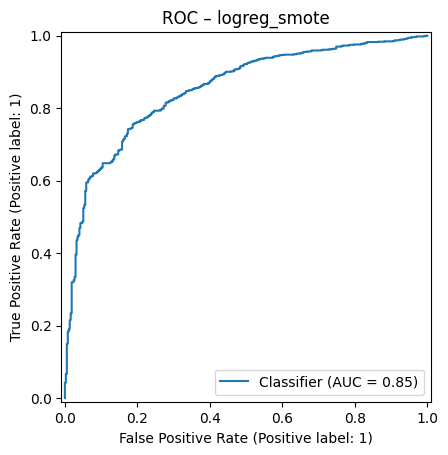

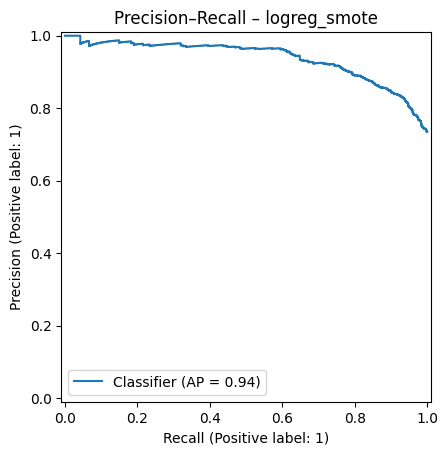

In [19]:
# =========================================
# CELDA FINAL — Tablas y Matrices de salida
# =========================================
import os, re, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay
)

# ---- Setup de carpetas y helpers ----
OUTPUT_DIR = Path("outputs")
FIG_DIR = OUTPUT_DIR / "figs"
TAB_DIR = OUTPUT_DIR / "tables"
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

def _fname(name: str, ext: str = "png") -> Path:
    name = re.sub(r"[^\w\-]+","_", name).strip("_")
    return FIG_DIR / f"{name}.{ext}"

def _savefig(fig, name: str, tight=True):
    p = _fname(name)
    if tight:
        fig.tight_layout()
    fig.savefig(p, dpi=160)
    plt.close(fig)
    return p

def _save_table(df: pd.DataFrame, name: str):
    cleaned_name = re.sub(r'[^\w\-]+','_', name)
    p = TAB_DIR / f"{cleaned_name}.csv"
    df.to_csv(p, index=False, encoding="utf-8-sig")
    return p

saved = {"figs": [], "tables": []}

# =========================
# 1) Reporte de clasificación (tabla) + matriz de confusión (fig)
# =========================
# best, best_name, best_pipe, y_test, X_test deben existir
y_pred = best["y_pred"]
rep_dict = classification_report(y_test, y_pred, target_names=["No canceló","Canceló"], output_dict=True)
rep_df = pd.DataFrame(rep_dict).T.reset_index().rename(columns={"index":"metric"})
saved["tables"].append(_save_table(rep_df, "classification_report_best"))

cm = confusion_matrix(y_test, y_pred)
fig_cm, ax_cm = plt.subplots(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax_cm)
ax_cm.set_title(f"Matriz de confusión – {best_name}")
ax_cm.set_xlabel("Predicción"); ax_cm.set_ylabel("Real")
saved["figs"].append(_savefig(fig_cm, f"confusion_matrix_{best_name}"))

# =========================
# 2) Curvas ROC y Precision–Recall (fig)
# =========================
if best.get("y_prob") is not None:
    fig_roc = plt.figure(figsize=(5,4))
    RocCurveDisplay.from_predictions(y_test, best["y_prob"])
    plt.title(f"ROC – {best_name}")
    saved["figs"].append(_savefig(fig_roc, f"roc_curve_{best_name}"))

    fig_pr = plt.figure(figsize=(5,4))
    PrecisionRecallDisplay.from_predictions(y_test, best["y_prob"])
    plt.title(f"Precision–Recall – {best_name}")
    saved["figs"].append(_savefig(fig_pr, f"pr_curve_{best_name}"))

# =========================
# 3) Tabla comparativa de modelos (res_df)
# =========================
if "res_df" in globals():
    # Orden útil: ROC AUC, F1, Recall
    out_res = res_df.copy().sort_values(["roc_auc","f1_1","recall_1"], ascending=False)
    saved["tables"].append(_save_table(out_res, "comparativa_modelos"))
else:
    print("⚠️ 'res_df' no encontrado, se omite tabla comparativa.")

# =========================
# 4) Tasas de cancelación por segmento (tablas + figs)
# =========================
def churn_rate_table(df, col, target="Cliente_cancelado"):
    t = (
        df.groupby(col)[target]
          .agg(rate="mean", n="count")
          .reset_index()
          .sort_values("rate", ascending=False)
    )
    return t

segmentos = [c for c in ["Tipo_de_Contrato","Metodo_Pago","Servicio_Internet","Género"] if c in df.columns]
for col in segmentos:
    t = churn_rate_table(df, col)
    saved["tables"].append(_save_table(t, f"tasa_cancelacion_por_{col}"))

    fig, ax = plt.subplots(figsize=(7,4))
    sns.barplot(data=t, x=col, y="rate", ax=ax)
    ax.set_title(f"Tasa de cancelación por {col}")
    ax.set_ylabel("Tasa (0–1)"); ax.set_xlabel(col)
    for p, n in zip(ax.patches, t["n"]):
        ax.text(p.get_x()+p.get_width()/2, p.get_height(), f"n={n}", ha="center", va="bottom", fontsize=9)
    plt.xticks(rotation=15)
    saved["figs"].append(_savefig(fig, f"tasa_cancelacion_{col}"))

# Bucket de antigüedad (si procede)
if "Meses_Contratados" in df.columns:
    bins = [-1,6,12,24,36,60,np.inf]
    labels = ["0-6","7-12","13-24","25-36","37-60","60+"]
    df["_BucketTenure"] = pd.cut(df["Meses_Contratados"].astype(float), bins=bins, labels=labels)
    t = churn_rate_table(df, "_BucketTenure")
    saved["tables"].append(_save_table(t, "tasa_cancelacion_por_bucket_tenure"))

    fig, ax = plt.subplots(figsize=(6,4))
    sns.barplot(data=t, x="_BucketTenure", y="rate", ax=ax)
    ax.set_title("Tasa de cancelación por bucket de antigüedad")
    ax.set_xlabel("Meses contratados"); ax.set_ylabel("Tasa (0–1)")
    for p, n in zip(ax.patches, t["n"]):
        ax.text(p.get_x()+p.get_width()/2, p.get_height(), f"n={n}", ha="center", va="bottom", fontsize=9)
    saved["figs"].append(_savefig(fig, "tasa_cancelacion_bucket_tenure"))

# =========================
# 5) Resumen numérico por clase (tabla)
# =========================
num_cols = [c for c in ["Meses_Contratados","Cobro_Mensual","Gasto_Total"] if c in df.columns]
if num_cols:
    desc = (df.groupby("Cliente_cancelado")[num_cols]
              .agg(["mean","median","std","min","max","count"]))
    desc.columns = ["_".join(col).strip() for col in desc.columns.values]
    desc = desc.reset_index()
    saved["tables"].append(_save_table(desc, "resumen_numerico_por_clase"))

# =========================
# 6) Correlación numéricas (fig + tabla)
# =========================
corr_cols = [c for c in ["Cliente_cancelado"] + num_cols if c in df.columns]
if len(corr_cols) >= 2:
    corr = df[corr_cols].corr()
    corr_out = corr.reset_index().rename(columns={"index":"variable"})
    saved["tables"].append(_save_table(corr_out, "matriz_correlacion"))
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, ax=ax)
    ax.set_title("Matriz de correlación (numéricas)")
    saved["figs"].append(_savefig(fig, "correlacion_numericas"))

# =========================
# 7) Importancias/coeficientes del mejor modelo (tabla + fig)
# =========================
try:
    ohe = best_pipe.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
    cat_names = ohe.get_feature_names_out(categorical_features).tolist() if categorical_features else []
    feat_names = (numeric_features or []) + cat_names
    clf = best_pipe.named_steps["clf"]

    if hasattr(clf, "feature_importances_"):
        s = pd.Series(clf.feature_importances_, index=feat_names).sort_values(ascending=False)
        saved["tables"].append(_save_table(s.reset_index().rename(columns={"index":"variable",0:"importancia"}), "importancias_rf"))
        fig, ax = plt.subplots(figsize=(8,5))
        sns.barplot(x=s.head(12).values, y=s.head(12).index, ax=ax)
        ax.set_title("Top-12 variables importantes (Random Forest)")
        ax.set_xlabel("Importancia"); ax.set_ylabel("")
        saved["figs"].append(_savefig(fig, "importancias_rf_top12"))
    elif hasattr(clf, "coef_"):
        coefs = pd.Series(clf.coef_.ravel(), index=feat_names)
        s = coefs.reindex(coefs.abs().sort_values(ascending=False).index)
        saved["tables"].append(_save_table(s.reset_index().rename(columns={"index":"variable",0:"coef"}), "coeficientes_logreg"))
        fig, ax = plt.subplots(figsize=(8,5))
        sns.barplot(x=s.head(12).values, y=s.head(12).index, ax=ax)
        ax.set_title("Top-12 coeficientes absolutos (LogReg)")
        ax.set_xlabel("Peso"); ax.set_ylabel("")
        saved["figs"].append(_savefig(fig, "coeficientes_logreg_top12"))
except Exception as e:
    print("ℹ️ No se pudieron calcular importancias/coeficientes:", e)

# =========================
# 8) ROC/PR guardadas como tablas (opcional)
# =========================
if best.get("y_prob") is not None:
    y_true = pd.Series(y_test, name="y_true").reset_index(drop=True)
    y_prob = pd.Series(best["y_prob"], name="y_prob").reset_index(drop=True)
    saved["tables"].append(_save_table(pd.concat([y_true, y_prob], axis=1), "scores_prob_test"))

# =========================
# Resumen de archivos guardados
# =========================
print("✅ Tablas guardadas:")
for p in saved["tables"]:
    print(" -", p)
print("\n🖼️ Figuras guardadas:")
for p in saved["figs"]:
    print(" -", p)